## クラウド設定

一度だけ実行すれば良い.

In [1]:
from pathlib import Path

config = """[default]
url=https://api.qiqb-cloud.jp
api_token=xxxxxxx
"""
Path("~/.oqtopus").expanduser().write_text(config)
print("Configuration saved.")

Configuration saved.


QIQBクラウドのリンク：https://www.qiqb-cloud.jp/  
「ジョブ」のタブで, 実行済み・実行中のジョブを確認することができます. 

クラウドパルス：https://github.com/orangekame3/oqtopus-sse-pulse  
コンフィグ：https://github.com/orangekame3/oqtopus-pulse-config



In [2]:
import json

## qubitの較正 

In [3]:
from quri_parts_oqtopus.backend import OqtopusSseBackend
from oqtopus_sse_pulse.adapter import QuriAdapter, collect_payloads_from_job, collect_session_from_job
from oqtopus_sse_pulse.plotters import plot_payload

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

DEVICE = "anemone" # デバイス名 (勉強会ではanemoneに固定)
backend = OqtopusSseBackend() # OqtopusSseBackendのインスタンスを作成

In [4]:
def experiment(program: str) -> list:
    """
    指定した実験プログラムを実行し, 測定結果のペイロードを返す関数.
    """

    # ジョブの実行
    job = backend.run_sse(
        file_path=f"{program}.py",
        device_id=f"{DEVICE}-pulse",
        name=program,
    )
    print(f"job_id = {job.job_id}")

    # ジョブの完了待ち
    job.wait_for_completion()
    print(f"job_status = {job.status}  elapsed={job.execution_time}")

    # QuriAdapterの作成
    adapter = QuriAdapter(backend)

    # 測定結果の取得
    payloads = collect_payloads_from_job(
        backend=adapter,
        job_id=job.job_id,
    )
    
    return payloads

## 各Qubitについて長時間測定し、エラーの時間を計測
### 以下が一回の測定サイクル（100 µs 間隔で反復）：
1. **状態準備（Prepare）**
    - |0>にセット
    - 各 qubit に π パルスを与え **|1⟩** に励起
    - （0→1 遷移の読み出し誤りを測りたい場合は |0⟩ を初期化）
2. **サンプリング idle（T1時間以下例えば 1 µs）**
    - この 1 µs における **|1⟩→|0⟩ の T1 崩壊** をエラーとして数える
    - 1 µs という短い時間幅により “小さい T1 の変化でも高感度に検出” できる
3. **同時読み出し（Measure）**
    - 全 qubit を同時測定
    - |0⟩ なら「error」とカウント
    - 時間とerror有無を記録
**(1)〜(3) をずっと繰り返す**

In [18]:
payloads = experiment("long_time_meas")
#Path("long_time_meas.json").write_text(json.dumps(payloads[0], ensure_ascii=False, indent=2))

job_id = 06938b7c-72c8-70fe-8000-5649aac7b04c


KeyboardInterrupt: 

In [11]:
Path("long_time_meas2.json").write_text(json.dumps(payloads, ensure_ascii=False, indent=2))

7310

/workspaces/oqtopus-sse-pulse/workspace/GW_mes_cosmic_ray/rhfunc.py:110: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(model, t_sec, projections, p0=p0, maxfev=20000)


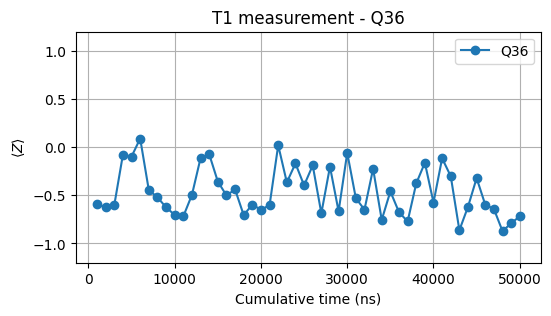

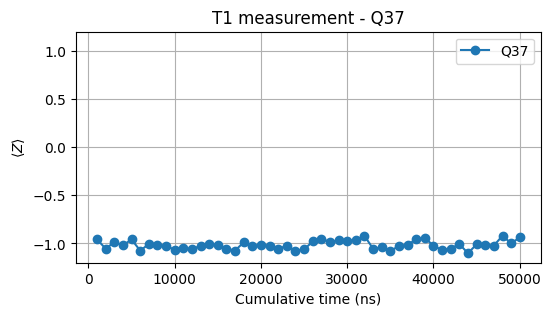

In [ ]:
from rhfunc import z_expectation_value

# qubit IDリストを取得
qubit_ids = list(payloads[0].keys())

data_dict = {}

for qid in qubit_ids:
    data_dict[qid] = {
        "time_list": payloads[0][qid]["time_list"],
        "data_real": payloads[0][qid]["data_real"],
        "data_imag": payloads[0][qid]["data_imag"]
    }

# 測定データ(data_real, data_imag)をZ期待値リストに変換
z_exp_dict = {}
for qid in qubit_ids:
    z_exp_dict[qid] = [z_expectation_value(r, i, qid) for r, i in zip(data_dict[qid]["data_real"], data_dict[qid]["data_imag"])]


# グラフ描画（各qubitを別々のグラフに）
# x軸は累積時間
for qid in qubit_ids:
    cumulative_time = np.cumsum(data_dict[qid]["time_list"])
    plt.figure(figsize=(6, 3))
    plt.plot(cumulative_time, z_exp_dict[qid], 'o-', label=qid)
    plt.xlabel('Cumulative time (ns)')
    plt.ylabel(r'$\langle Z \rangle$')
    plt.title(f'Z meas - {qid}')
    plt.ylim(-1.2, 1.2)
    plt.grid(True)
    plt.legend()
    plt.show()

Q36: [1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Q37: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


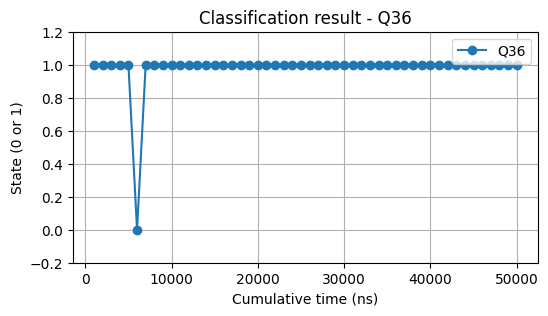

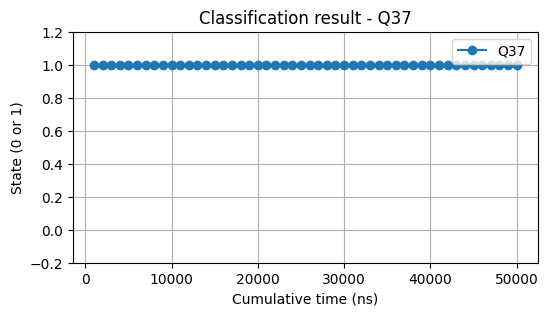

In [13]:
from rhfunc import classifier

# 各qubitの測定データを分類
classified_dict = {}

for qid in qubit_ids:
    classified_list = []
    for r, i in zip(data_dict[qid]["data_real"], data_dict[qid]["data_imag"]):
        state = classifier(r, i, qid)
        classified_list.append(state)
    classified_dict[qid] = classified_list

# 分類結果の確認（各qubitの最初の10個を表示）
for qid in qubit_ids:
    print(f"{qid}: {classified_dict[qid][:10]}")

# プロット（各qubitを別々のグラフに）
for qid in qubit_ids:
    cumulative_time = np.cumsum(data_dict[qid]["time_list"])
    plt.figure(figsize=(6, 3))
    plt.plot(cumulative_time, classified_dict[qid], 'o-', label=qid)
    plt.xlabel('Cumulative time (ns)')
    plt.ylabel('State (0 or 1)')
    plt.title(f'Classification result - {qid}')
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    plt.legend()
    plt.show()